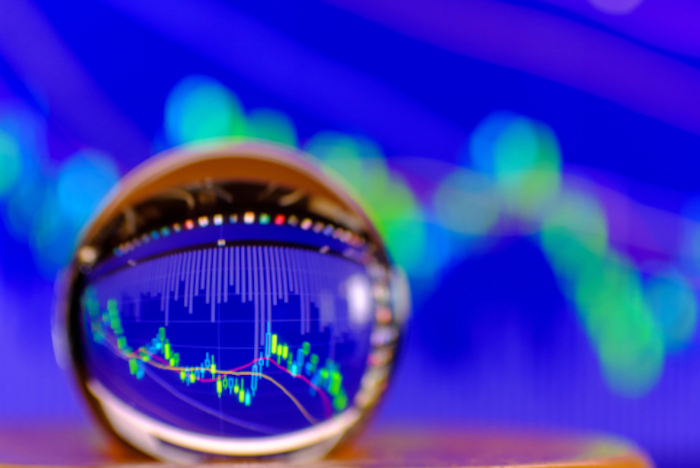

# **Machine Learning Cryptocurrency Price Prediction Tool**

This Jupyter Notebook provides an interactive app that allows you to predict and backtest cryptocurrency prices using an LSTM (Long Short-Term Memory) Neural Network model. The app fetches cryptocurrency data from the Coingecko API, preprocesses the data, trains an LSTM model, and performs a backtest to evaluate the model's performance.

### How to Use the App:

- Select a cryptocurrency from the dropdown list.
- Enter the number of days for data selection.
- Enter the initial investment amount for the backtest.
- Specify the number of epochs, batch size, window size, LSTM units,
trainable layers, and layers to freeze.
- Click the "Train" button to train the model with the specified settings.
- After training, click the "Backtest" button to evaluate the model's performance and view the backtesting results.
- Click the "Save Model" button to save the trained model.
- Click the "Restart" button to reset the widgets and train a new model.

### Code Explanation:

The code in this notebook is divided into several sections:

**Import Libraries, Modules & Dependencies:** This section imports the required libraries and dependencies for the app.

**Data Fetching and Preprocessing:** This section defines functions to fetch cryptocurrency data from the Coingecko API and preprocess the data by calculating technical analysis (TA) features such as Simple Moving Average (SMA), Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Bollinger Bands.

**Data Preparation:** This section defines functions to prepare the data for training and backtesting. The data is split into training and testing sets, scaled using MinMaxScaler, and converted into input-output sequences.

**Model Building:** This section defines functions to build the LSTM model. The model architecture includes LSTM layers, dropout layers, and a dense output layer. It also provides options to set the number of trainable layers and freeze specific layers.

**Model Training:** This section defines functions to train the LSTM model using the prepared data. It includes early stopping to prevent overfitting and returns the trained model and training history.

**Button Click Event Handlers:** This section defines functions to handle the events when the train, backtest, save model, and reset app buttons are clicked. These functions perform the respective actions and display the results.

**Widget Creation:** This section creates the interactive widgets using the ipywidgets library. The widgets include dropdowns, input fields, buttons, and an output widget for displaying messages.

**Widget Display:** This section displays the title, app explanation, and the arranged widgets on the notebook interface.

### Note
Before running the code, make sure to install the required libraries by running the following command:

`!pip install requests datetime numpy pandas matplotlib scikit-learn tensorflow ipywidgets
`

HTML(value="<h1 style='text-align: center;'>Cryptocurrency LSTM Predictor & Backtester</h1>")

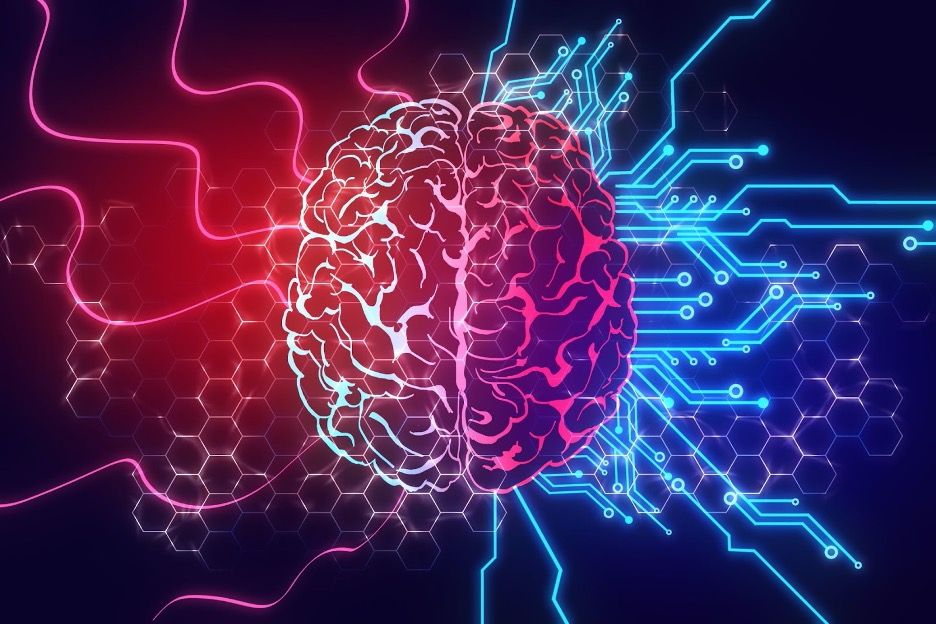

HTML(value='\n<h2>About the App</h2>\n<p>This app allows you to predict and backtest cryptocurrency prices usi…

In [25]:
# Import Libraries, Modules & Dependencies
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from IPython.display import display, clear_output, Image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# Declare global variables
df = None
train_predictions = None
test_predictions = None
window_size = None
model = None

# Function to fetch crypto data from the Coingecko API
def fetch_coin_data(coin_id, days):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=usd&days={days}"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data["prices"], columns=["timestamp", "price"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
    df.set_index("timestamp", inplace=True)
    return df

# Function to calculate TA features
def calculate_ta_features(df):
    # Calculate TA features
    df["sma_20"] = df["price"].rolling(window=20).mean()
    df["sma_50"] = df["price"].rolling(window=50).mean()
    df["rsi"] = calculate_rsi(df["price"])
    df["macd"], df["signal_line"] = calculate_macd(df["price"])
    df["upper_band"], df["lower_band"] = calculate_bollinger_bands(df["price"])
    # Add more features as needed
    return df

# Function to calculate RSI
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gains = delta.mask(delta < 0, 0)
    losses = -delta.mask(delta > 0, 0)
    avg_gain = gains.rolling(window).mean()
    avg_loss = losses.rolling(window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    ema_short = prices.ewm(span=short_window, adjust=False).mean()
    ema_long = prices.ewm(span=long_window, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(prices, window=20, num_std=2):
    rolling_mean = prices.rolling(window).mean()
    rolling_std = prices.rolling(window).std()
    upper_band = rolling_mean + num_std * rolling_std
    lower_band = rolling_mean - num_std * rolling_std
    return upper_band, lower_band

# Function to prepare the data
def prepare_data(df, target_column, window_size, train_ratio=0.8):
    # Split data into train and test sets using time series splitting
    tscv = TimeSeriesSplit(n_splits=6)  # Set the number of splits as needed, once the optimal number is found we can introduce a random state for reproducability
    for train_index, test_index in tscv.split(df):
        train_data = df.iloc[train_index]
        test_data = df.iloc[test_index]

        # Fill NaN values with 0
        train_data_filled = train_data.fillna(0)
        test_data_filled = test_data.fillna(0)

        # Scale the data
        scaler = MinMaxScaler()
        train_data_scaled = scaler.fit_transform(train_data_filled)
        test_data_scaled = scaler.transform(test_data_filled)

        # Create input-output pairs
        X_train, y_train = create_sequences(train_data_scaled, window_size, target_column)
        X_test, y_test = create_sequences(test_data_scaled, window_size, target_column)

        return X_train, y_train, X_test, y_test

# Function to create sequences
def create_sequences(data, window_size, target_column):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size])
        y.append(data[i + window_size][target_column])
    return np.array(X), np.array(y)

# Function to build model
def build_model(input_shape, lstm_units, trainable_layers=None, freeze_layers=None):
    global model  # Access the global model object
    model = keras.Sequential()
    model.add(layers.LSTM(lstm_units, input_shape=input_shape, trainable=False))
    model.add(Dropout(0.2))  # Add dropout layer with a dropout rate of 0.2

    if trainable_layers is not None:
        for layer in model.layers[-trainable_layers:]:
            layer.trainable = True

    if freeze_layers is not None:
        for layer in model.layers[:freeze_layers]:
            layer.trainable = False

    model.add(layers.Dense(1))
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

# Function to train model
def train_model(X_train, y_train, X_test, y_test, epochs, batch_size, lstm_units, trainable_layers=None, freeze_layers=None):
    global model  # Access the global model object
    model = build_model(X_train.shape[1:], lstm_units)
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)  # Stop training if validation loss doesn't improve for 10 epochs
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping])
    return model, history

# Function to handle the train button clicked event
def train_lstm_button_clicked(b):
    global df, train_predictions, test_predictions  # Access the global variables

    # Validate input values
    if (days_input.value is None or epoch_input.value is None or
        batch_size_input.value is None or window_size_input.value is None or
        lstm_units_input.value is None or days_input.value == 0 or
        epoch_input.value == 0 or batch_size_input.value == 0 or
        window_size_input.value == 0 or lstm_units_input.value == 0):
        with output:
            clear_output()
            print(" ⚠️ Please enter all the required values. ⚠️")
        return

    coin_id = coin_id_dropdown.value
    days = int(days_input.value)
    epoch_duration = int(epoch_input.value)
    batch_size = int(batch_size_input.value)
    window_size = int(window_size_input.value)
    lstm_units = int(lstm_units_input.value)
    trainable_layers = int(trainable_layers_input.value)
    freeze_layers = int(freeze_layers_input.value)

    # Fetch data
    df = fetch_coin_data(coin_id, days)

    # Calculate TA features
    df = calculate_ta_features(df)

    # Prepare data
    target_column = 0
    train_ratio = 0.8
    X_train, y_train, X_test, y_test = prepare_data(df, target_column, window_size, train_ratio)

    # Display "Training model" message
    with output:
        clear_output()
        print("\n\n Training Model 🪄🔮\n\n Please Stand By...\n")

    # Train the model
    model, history = train_model(X_train, y_train, X_test, y_test, epoch_duration, batch_size, lstm_units, trainable_layers=trainable_layers, freeze_layers=freeze_layers)

    # Success message
    with output:
        clear_output()
        print("\n Model Successfully Trained! ✅\n\n Collating Results 🧮\n\n Please Stand By...\n")

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate evaluation metrics
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)

    test_mae = mean_absolute_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_rmse = np.sqrt(test_mse)

    # Calculate additional evaluation metrics
    r_squared = r2_score(y_test, test_predictions)  # R-squared
    mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100  # MAPE
    mase = mean_absolute_error(y_test, test_predictions) / np.mean(np.abs(y_train - np.roll(y_train, 1)))  # MASE
    correlation = np.corrcoef(y_test.flatten(), test_predictions.flatten())[0, 1]  # Correlation coefficient
    medae = median_absolute_error(y_test, test_predictions)  # Median Absolute Error
    explained_var = explained_variance_score(y_test, test_predictions)  # Explained Variance Score

    # Model performance summary
    print("\nModel Performance Summary")
    print("If the training metrics (MAE, MSE, RMSE) are significantly lower than the testing metrics, it could indicate potential overfitting\nof the model to the training data.")
    print("Lower values of MAE, MSE, and RMSE indicate better model performance, with values closer to zero being desirable.")
    print("It is important to compare the testing metrics with the metrics of other models or baseline models to assess the relative performance.")

    # Print evaluation metrics
    print("\nLSTM Model Evaluation Metrics")
    print(f"Training MAE: {train_mae}")
    print(f"Training MSE: {train_mse}")
    print(f"Training RMSE: {train_rmse}")
    print(f"\nTesting MAE: {test_mae}")
    print(f"Testing MSE: {test_mse}")
    print(f"Testing RMSE: {test_rmse}")

    # Additional evaluation metrics
    print("\nAdditional Evaluation Metrics")
    print(f"MAPE: {mape}")
    print(f"MASE: {mase}")
    print(f"Correlation: {correlation}")
    print(f"R-squared: {r_squared:.4f}")
    print(f"Median Absolute Error: {medae:.4f}")
    print(f"Explained Variance Score: {explained_var:.4f}")

    # Interpretation of additional evaluation metrics
    print("\nInterpretation of Additional Evaluation Metrics")
    print("MAPE:")
    print("The Mean Absolute Percentage Error measures the average percentage difference between the predicted values and the actual values.\nIt represents the model's average prediction error as a percentage of the true values. Lower values are desirable.\n")
    print("MASE:")
    print("The Mean Absolute Scaled Error compares the mean absolute error of the model with the mean absolute error of a naive baseline model.\nIt provides a measure of the model's performance relative to a simple baseline model. Values less than 1 indicate that the model performs\nbetter than the baseline.\n")
    print("Correlation:")
    print("The Correlation coefficient measures the strength and direction of the linear relationship between the predicted values and the actual\nvalues. It ranges from -1 to 1, with 1 indicating a perfect positive correlation, -1 indicating a perfect negative correlation, and 0\nindicating no correlation. Higher absolute values closer to 1 indicate a stronger correlation.\n")
    print("R-squared:")
    print("The R-squared score measures the proportion of the variance in the dependent variable that is explained by the independent variables.")
    print("A higher R-squared score indicates a better fit of the model to the data.")
    print("It is important to consider the limitations of R-squared, such as its sensitivity to the number of independent variables.\n")
    print("Median Absolute Error:")
    print("The Median Absolute Error represents the median of the absolute differences between the predicted values and the true values.")
    print("It provides a robust measure of the average magnitude of errors, being less sensitive to outliers compared to mean absolute error.\n")
    print("Explained Variance Score:")
    print("The Explained Variance Score measures the proportion of the variance in the dependent variable that can be explained by the independent\nvariables.")
    print("A higher Explained Variance Score indicates a better fit of the model to the data.\n")

    # Display model performance metrics
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Training and Validation Loss Plot
    print("\nTraining and Validation Loss Plot")
    print("The training loss represents the error of the model on the training data during each epoch of training.")
    print("The validation loss represents the error of the model on the validation data during each epoch of training.")
    print("An optimal training and validation loss plot should show a decreasing trend for both lines, indicating that the model is\nlearning and improving its performance.")
    print("However, it is important to avoid overfitting, which is indicated by a significant gap between the training and validation\nloss lines.")
    print("If the training loss continues to decrease while the validation loss starts to increase or stagnate, it suggests overfitting.\n")

    # Display correlation plot
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Plot")
    plt.show()

    # Print interpretation of correlation heatmap
    print("\nCorrelation Heatmap")
    print("A correlation heatmap visualises the pairwise correlation between different variables in the dataset.")
    print("Each cell in the heatmap represents the correlation coefficient between two variables.")
    print("The correlation coefficient measures the strength and direction of the linear relationship between variables.")
    print("The values range from -1 to 1, where -1 indicates a perfect negative correlation, 1 indicates a perfect positive correlation,\nand 0 indicates no correlation.")
    print("A dark shade or high positive/negative value suggests a strong correlation, while a light shade or value close to 0 suggests\na weak or no correlation.")
    print("The correlation heatmap helps identify relationships between variables and can be useful in feature selection or identifying\nmulticollinearity, which is a situation in which two or more independent variables in a regression model are highly correlated with each other.\n")

    # Function to generate buy/sell signals using moving average crossover
    def generate_signals(df, short_ma_period, long_ma_period):
        df["short_ma"] = df["price"].rolling(window=short_ma_period).mean()
        df["long_ma"] = df["price"].rolling(window=long_ma_period).mean()

        df["signal"] = 0
        df.loc[df["short_ma"] > df["long_ma"], "signal"] = 1
        df.loc[df["short_ma"] < df["long_ma"], "signal"] = -1

        df["filtered_signal"] = df["signal"].diff()

        return df

    # Generate signals using moving average crossover with short-term MA period of 50 and long-term MA period of 200
    df = generate_signals(df, short_ma_period=50, long_ma_period=200)

    # Visualize predictions vs actual values with buy/sell signals
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[window_size:window_size + len(train_predictions)], train_predictions, label="Train Predictions")
    plt.plot(df.index[-len(test_predictions):], test_predictions, label="Test Predictions")
    plt.plot(df.index[window_size:-window_size], df["price"].iloc[window_size:-window_size], label="Actual")

    # Plot buy/sell signals
    buy_signals = df[df["signal"] == 1]
    sell_signals = df[df["signal"] == -1]
    plt.scatter(buy_signals.index, buy_signals["price"], marker="^", color="green", label="Buy Signal")
    plt.scatter(sell_signals.index, sell_signals["price"], marker="v", color="red", label="Sell Signal")
    plt.title("Price Predictions with Buy/Sell Signals (Moving Average Crossover)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Price Predictions with Buy/Sell Signals
    print("\nPrice Predictions with Buy/Sell Signals")
    print("The plot shows the predicted prices of the cryptocurrency along with the actual prices.")
    print("The blue line represents the predicted prices for the training period.")
    print("The orange line represents the predicted prices for the testing period.")
    print("The green line represents the actual prices.")
    print("The green triangles indicate the buy signals, which suggest favorable conditions for buying.")
    print("The red triangles indicate the sell signals, which suggest favorable conditions for selling.")
    print("These signals are generated based on the MACD (Moving Average Convergence Divergence) indicator.")
    print("MACD helps identify potential trends and changes in momentum in the price of an asset.")
    print("By comparing the short-term and long-term moving averages, MACD provides insights into potential buy and sell signals.\n")

# Function to handle the backtest button clicked event
def backtest_button_clicked(b):
    global df, train_predictions, test_predictions, window_size  # Access the global variables

    if df is None:
        with output:
            clear_output()
            print("\n\n ⚠️ Please train the model first. ⚠️")
        return

    with output:
        clear_output()
        print("\n\n Backtest Successfully Completed! ✅\n")

    # Assign the value of window_size based on user input
    window_size = int(window_size_input.value)

    # Get the value of initial investment amount
    initial_investment = initial_investment_input.value

    # Backtest the model
    df["predicted_price"] = np.nan
    df.iloc[window_size:window_size + len(train_predictions), df.columns.get_loc("predicted_price")] = train_predictions.flatten()

    test_predictions_start_index = window_size + len(train_predictions) + window_size
    test_predictions_end_index = test_predictions_start_index + len(test_predictions)

    df.iloc[test_predictions_start_index:test_predictions_end_index, df.columns.get_loc("predicted_price")] = test_predictions.flatten()

    df["position"] = np.where(df["predicted_price"].shift(1) < df["predicted_price"], 1, -1)
    df["strategy_returns"] = df["position"] * df["price"].pct_change()

    # Calculate cumulative returns
    df["cumulative_returns"] = (1 + df["strategy_returns"]).cumprod()

    # Calculate total strategy returns
    total_strategy_returns = (df["cumulative_returns"][-1] - 1) * initial_investment

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["cumulative_returns"], label="Strategy Returns")
    plt.title("Cumulative Returns - Backtest Results")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)

    # Add additional information
    plt.figtext(0.5, -0.1, f"Total Strategy Returns: {df['cumulative_returns'][-1] - 1:.2%}", ha="center")
    plt.figtext(0.5, -0.12, f"Total Trades: {df['position'].diff().abs().sum()}", ha="center")
    plt.figtext(0.5, -0.14, f"Win Rate: {df['strategy_returns'][df['strategy_returns'] > 0].count() / df['strategy_returns'][df['strategy_returns'] != 0].count():.2%}", ha="center")

    # Display the cumulative returns plot
    plt.show()

    # Print interpretation
    print("\nBacktest Results")
    print("This plot shows the cumulative returns of the strategy based on the backtesting results.")
    print("The cumulative returns represent the performance of the strategy over time.")
    print("A rising curve indicates positive returns, while a declining curve suggests negative returns.")
    print("The 'Strategy Returns' line represents the cumulative returns of the strategy.")
    # Print additional information
    print(f"\nTotal Strategy Returns: ${total_strategy_returns:.2f}")
    print("It is calculated as the difference between the final cumulative returns and the initial investment amount.")
    print("A positive value signifies a profitable strategy, while a negative value indicates losses.")
    print("\nTotal Trades: This metric reveals the total number of buy/sell trades made by the strategy during the backtesting period.")
    print("It provides insight into the frequency of trading activity and the level of engagement of the strategy.")
    print("\nWin Rate: This metric represents the win rate of the strategy, calculated as the percentage of winning trades.")
    print("It indicates the proportion of trades that resulted in positive returns out of all trades executed.")
    print("A higher win rate suggests a higher probability of profitable trades, but it should be considered alongside other performance metrics.")

# Function to handle the save model button clicked event
def save_model_button_clicked(b):
    global model  # Access the global model object
    if model is None:
        with output:
          clear_output()
          print("\n\n\n\n ⚠️ Please train the model first. ⚠️")
        return

    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    model_filename = f"my_model_{timestamp}.h5"
    model.save(model_filename)

    with output:
        clear_output()
        print(f"\n\n\n\n 💾 Model saved successfully as\n '{model_filename}' ✅")

# Function to handle the reset app button clicked event
def reset_app(b):
  with output:
    clear_output()
    print("\n\n\n\n\n\n 🔁 Restart Successful! ✅")
    # Reset the widget values
    coin_id_dropdown.value = 'ripple'
    days_input.value = 0
    initial_investment_input.value = 0
    epoch_input.value = 0
    batch_size_input.value = 0
    window_size_input.value = 0
    lstm_units_input.value = 0
    trainable_layers_input.value = 1
    freeze_layers_input.value = 0

# Create widgets
# Coin ID dropdown
coin_id_dropdown = widgets.Dropdown(
    options=['algorand', 'avalanche-2', 'bitcoin', 'cardano', 'casper-network', 'chainlink', 'dogecoin', 'ethereum', 'filecoin', 'flare-networks',
             'hedera-hashgraph', 'litecoin', 'matic-network', 'polkadot', 'quant-network', 'ripple', 'shiba-inu', 'solana', 'songbird', 'stellar', 'tron', 'vechain',
             'velo', 'xdce-crowd-sale'],  # Add more options as needed
    value='ripple',
    description='Coin ID:'
)

# Days input
days_input = widgets.IntText(
    value=0,
    description='Days:'
)

# Epoch duration input
epoch_input = widgets.IntText(
    value=0,
    description='Epochs:'
)

# Batch size input
batch_size_input = widgets.IntText(
    value=0,
    description='Batch Size:'
)

# Window size input
window_size_input = widgets.IntText(
    value=0,
    description='Window Size:'
)

# LSTM Units input
lstm_units_input = widgets.IntText(
    value=0,
    description='LSTM Units:'
)

# Trainable layers input
trainable_layers_input = widgets.IntText(
    value=1, # 1 trainable layer set as placeholder
    description='Trainable:'
)

# Freeze specific layers input
freeze_layers_input = widgets.IntText(
    value=0,
    description='Freeze:'
)

# Initial investment input
initial_investment_input = widgets.FloatText(
    value=0,
    description='Investment:'
)

# Train LSTM model button
train_lstm_button = widgets.Button(
    description='Train LSTM',
    button_style='success'
)
train_lstm_button.on_click(train_lstm_button_clicked)

# Backtest button
backtest_button = widgets.Button(
    description='Backtest',
    button_style='info'
)
backtest_button.on_click(backtest_button_clicked)

# Save Model button
save_model_button = widgets.Button(
    description='Save Model',
    button_style='danger'
)
save_model_button.on_click(save_model_button_clicked)

# Restart button
restart_button = widgets.Button(
    description='Restart',
    button_style='warning'
)
restart_button.on_click(reset_app)

# Output widget for displaying messages
output = widgets.Output()

# User Interface
# App title & explanation
title = widgets.HTML("<h1 style='text-align: center;'>Cryptocurrency LSTM Predictor & Backtester</h1>")
explanation_text = """
<h2>About the App</h2>
<p>This app allows you to predict and backtest cryptocurrency prices using an LSTM (Long Short-Term Memory) model.</p>
<p>Instructions:</p>
<ol>
<li>Select a cryptocurrency from the dropdown list.</li>
<li>Enter the number of days for data selection.</li>
<li>Enter the initial investment amount for the Backtest.</li>
<li>Specify the number of epochs, batch size, window size, LSTM units, trainable layers, and layers to freeze.</li>
<li>Click the "Train" button to train the model with the specified settings.</li>
<li>After training, click the "Backtest" button to evaluate the model's performance and view the backtesting results.</li>
<li>Click the "Save Model" button to save the trained model.</li>
<li>Click the "Restart" button to reset the widgets, you can then train a new model & compare it to previous models.</li>
</ol>
"""

# Load the image
image_path = "/content/drive/MyDrive/ml_brain.jpg"
image_widget = Image(filename=image_path, format='jpg')

# Set the desired width of the image
image_widget.width = 230

# Arrange widgets
inputs_column = widgets.VBox([coin_id_dropdown, days_input, initial_investment_input, epoch_input, batch_size_input])
params_column = widgets.VBox([window_size_input, lstm_units_input, trainable_layers_input, freeze_layers_input])
buttons_column = widgets.VBox([train_lstm_button, backtest_button, save_model_button, restart_button])
output_column = widgets.VBox([output])
widgets_box = widgets.HBox([inputs_column, params_column, buttons_column, output_column])

# Configure & Display the User Interface
display(title, image_widget, widgets.HTML(value=explanation_text), widgets_box)